In [1]:
! which python

/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/bin/python


In [2]:
import sys
sys.path.append('..')

In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

import optuna
import lightgbm as lgb

/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [4]:
df1 = pd.read_excel('../dataset/train.xlsx')
df2 = pd.read_excel('../dataset/test.xlsx')

In [5]:
train = df1.copy()
test = df2.copy()

In [6]:
train.head()

,id,age,sector,edu,marital_status,field,family_rel,gender,investment_gain,investment_loss,working_hours,high_income
0,1,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,Male,2174,0,40,no
1,2,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,13,no
2,3,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,Male,0,0,40,no
3,4,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Male,0,0,40,no
4,5,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Female,0,0,40,no


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               32561 non-null  int64 
 1   age              32561 non-null  int64 
 2   sector           32561 non-null  object
 3   edu              32561 non-null  object
 4   marital_status   32561 non-null  object
 5   field            32561 non-null  object
 6   family_rel       32561 non-null  object
 7   gender           32561 non-null  object
 8   investment_gain  32561 non-null  int64 
 9   investment_loss  32561 non-null  int64 
 10  working_hours    32561 non-null  int64 
 11  high_income      32561 non-null  object
dtypes: int64(5), object(7)
memory usage: 3.0+ MB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               16281 non-null  int64 
 1   age              16281 non-null  int64 
 2   sector           16281 non-null  object
 3   edu              16281 non-null  object
 4   marital_status   16281 non-null  object
 5   field            16281 non-null  object
 6   family_rel       16281 non-null  object
 7   gender           16281 non-null  object
 8   investment_gain  16281 non-null  int64 
 9   investment_loss  16281 non-null  int64 
 10  working_hours    16281 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 1.4+ MB


# EDA

### Compare distribution of train and test set

In [9]:
def plot_distribution(df, column):
    # Create a figure with 2 subplots
    fig, axs = plt.subplots(1, 1, figsize=(10, 4), sharex=True)

    # Check if the column is numeric or categorical
    if pd.api.types.is_numeric_dtype(df[column]):
        print(f'{column} is numeric')
        # Numeric feature: Use line chart
        sns.histplot(df1[column], bins=30, kde=True, ax=axs, color='blue', label='train ' + column, alpha=0.5)

        # Add density plots for a smooth distribution
        sns.kdeplot(df1[column], ax=axs, color='blue', alpha=0.5)
    else:
        print(f'{column} is categorical')
        # Categorical feature: Use bar chart
        sns.countplot(x=column, data=df, ax=axs, color='blue', alpha=0.5)

    # Set titles and labels
    axs.set_title(f'df {column} Distribution')
    axs.set_xlabel('')
    axs.set_ylabel('Count')

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def compare_dataframes(df1, df2):
    """
    This function takes two pandas DataFrames as input and draws plots to compare
    each feature's distribution of the two DataFrames using Seaborn. Bar charts are 
    used for categorical features, and line charts are used for numeric features.

    Parameters:
    df1 (pd.DataFrame): The first DataFrame.
    df2 (pd.DataFrame): The second DataFrame.
    """
    
    # Ensure that both DataFrames have the same columns
    # if not df1.columns.equals(df2.columns):
    #     raise ValueError("DataFrames must have the same columns")
    
    # Loop over each column in the DataFrames
    for column in df1.columns:
        if column not in ['high_income', 'id']:
            # Create a figure with 2 subplots
            fig, axs = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

            # Check if the column is numeric or categorical
            if pd.api.types.is_numeric_dtype(df1[column]):
                print(f'{column} is numeric')
                # Numeric feature: Use line chart
                sns.histplot(df1[column], bins=30, kde=True, ax=axs[0], color='blue', label='train ' + column, alpha=0.5)
                sns.histplot(df2[column], bins=30, kde=True, ax=axs[1], color='red', label='test ' + column, alpha=0.5)

                # Add density plots for a smooth distribution
                sns.kdeplot(df1[column], ax=axs[0], color='blue', alpha=0.5)
                sns.kdeplot(df2[column], ax=axs[1], color='red', alpha=0.5)
            else:
                print(f'{column} is categorical')
                # Categorical feature: Use bar chart
                sns.countplot(x=column, data=df1, ax=axs[0], color='blue', alpha=0.5)
                sns.countplot(x=column, data=df2, ax=axs[1], color='red', alpha=0.5)

            # Set titles and labels
            axs[0].set_title(f'df1 {column} Distribution')
            axs[0].set_xlabel('')
            axs[0].set_ylabel('Count')
            axs[1].set_title(f'df2 {column} Distribution')
            axs[1].set_xlabel(column)
            axs[1].set_ylabel('Count')

            # Adjust layout and show the plots
            plt.tight_layout()
            plt.show()

# compare_dataframes(train, test)

# Pre-processing

### Strip

In [11]:
categorical_cols = train.select_dtypes(include=['object']).columns

In [12]:
for col in categorical_cols:
    if col != 'high_income':
        train[col] = train[col].str.strip()
        test[col] = test[col].str.strip()
    else:
        train[col] = train[col].str.strip()

### Binning

In [52]:
import pandas as pd

def bin_column_by_quantile(df1, column, num_bins=4, labels=None):
    """
    Divides a specified column in a DataFrame into bins based on quantiles.

    Parameters:
    df1 (pd.DataFrame): The DataFrame containing the column to be binned.
    column (str): The name of the column to be binned.
    num_bins (int): The number of quantile-based bins to create. Default is 4 (quartiles).
    labels (list): Optional list of labels for the bins. Must be the same length as num_bins.

    Returns:
    pd.DataFrame: The DataFrame with an additional column for the binned values.
    """
    
    df = df1.copy()
    if labels is not None and len(labels) != num_bins:
        raise ValueError("Length of labels must be equal to num_bins")
    
    # Create the bin edges based on quantiles
    bin_edges = pd.qcut(df[column], q=num_bins, labels=labels, retbins=True)[1]
    
    # Bin the column based on the calculated bin edges
    binned_column = pd.cut(df[column], bins=bin_edges, labels=labels, include_lowest=True)
    
    # Create a new column name for the binned values
    binned_column_name = column + '_binned'
    
    # Add the binned column to the DataFrame
    df[binned_column_name] = binned_column
    
    return df


In [88]:
# train = bin_column_by_quantile(train, 'age', num_bins=4, labels=[1, 2, 3, 4])
# test = bin_column_by_quantile(test, 'age', num_bins=4, labels=[1, 2, 3, 4])
train.head()

,id,age,sector,edu,marital_status,field,family_rel,gender,investment_gain,investment_loss,working_hours,high_income
0,1,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,Male,2174,0,40,no
1,2,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,13,no
2,3,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,Male,0,0,40,no
3,4,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Male,0,0,40,no
4,5,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Female,0,0,40,no


In [89]:
def bin_column_by_custom_quantiles(df, column, quantiles=[0.25, 0.75], labels=None):
    """
    Divides a specified column in a DataFrame into bins based on custom quantiles.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the column to be binned.
    column (str): The name of the column to be binned.
    quantiles (list): A list of quantiles to use for binning. Default is [0.25, 0.75].
    labels (list): Optional list of labels for the bins. Must be one less than the length of quantiles + 1.

    Returns:
    pd.DataFrame: The DataFrame with an additional column for the binned values.
    """
    
    # Calculate the quantile values
    quantile_values = df[column].quantile(quantiles).tolist()
    
    # Define the bin edges
    bins = [-float('inf')] + quantile_values + [float('inf')]
    
    # If labels are not provided, create default labels
    if labels is None:
        labels = [i+1 for i in range(len(bins) - 1)]
    
    # Ensure the number of labels matches the number of bins
    if len(labels) != len(bins) - 1:
        raise ValueError("The number of labels must be one less than the number of bins")
    
    # Bin the column based on the calculated bin edges
    binned_column = pd.cut(df[column], bins=bins, labels=labels, include_lowest=True)
    
    # Create a new column name for the binned values
    binned_column_name = column + '_binned'
    
    # Add the binned column to the DataFrame
    df[binned_column_name] = binned_column
    
    return df

In [90]:
# df_binned = bin_column_by_custom_quantiles(train, 'age', quantiles=[0.1, 0.5, 0.9])
# df_binned.head()

### Processing

##### edu

In [91]:
train['edu'].value_counts()

edu
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: count, dtype: int64

In [92]:
def convert_edu(status):
    status_stripped = str(status).strip()
    if status_stripped in ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 'HS-grad']:
        return 'undergrad'
    elif status_stripped in ['Some-college', 'Bachelors', 'Masters', 'Assoc-voc', 'Assoc-acdm', 'Prof-school', 'Doctorate']:
        return 'grad'

In [93]:
train['edu_new'] = train['edu'].apply(convert_edu)
test['edu_new'] = test['edu'].apply(convert_edu)

In [96]:
test['edu_new'].value_counts()

edu_new
grad         8843
undergrad    7438
Name: count, dtype: int64

##### marital_status

In [97]:
train['marital_status'].value_counts()

marital_status
Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: count, dtype: int64

In [98]:
def convert_marital_status(status):
    status_stripped = status.strip()

    if status_stripped in ['Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse']:
        return 'married'
    elif status_stripped in ['Never-married', 'Separated', 'Widowed']:
        return 'single'
    elif status_stripped == 'Divorced':
        return 'divorced'
    else:
        return 'unknown'

train['marital_status_new'] = train['marital_status'].apply(convert_marital_status)
test['marital_status_new'] = test['marital_status'].apply(convert_marital_status)

In [99]:
train['marital_status_new'].value_counts()

marital_status_new
married     15417
single      12701
divorced     4443
Name: count, dtype: int64

##### high_income

In [102]:
income_mapping = {'no': 0, 'yes': 1}
train['target'] = train['high_income'].map(income_mapping)

##### field

field is categorical


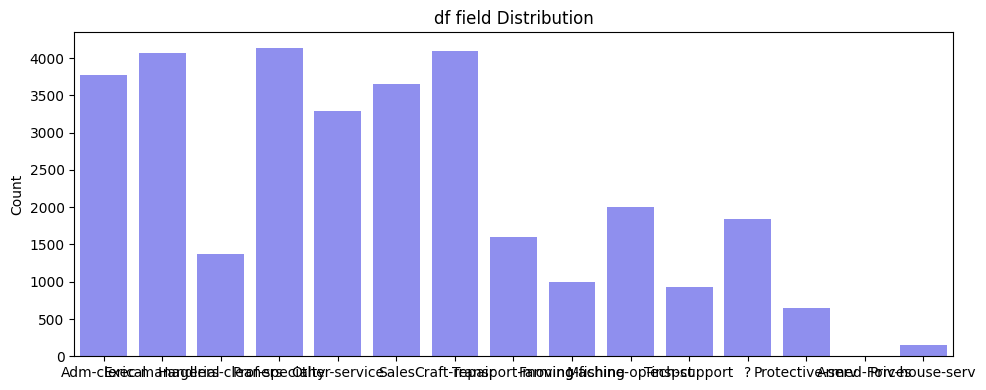

In [103]:
plot_distribution(train, 'field')

In [104]:
def fill_missing_categorical(df, column):
    df[column] = df[column].replace('?', np.nan)

    if df[column].notna().all():
        return df

    known = df[df[column].notna()]
    unknown = df[df[column].isna()]

    le = LabelEncoder()
    known[column] = le.fit_transform(known[column])
    X_known = known.drop(column, axis=1)
    y_known = known[column]

    categorical_cols = X_known.select_dtypes(include=['object']).columns

    le_cat = preprocessing.LabelEncoder()
    X_known[categorical_cols] = X_known[categorical_cols].apply(lambda col: le_cat.fit_transform(col.astype(str)))

    clf = RandomForestClassifier()
    clf.fit(X_known, y_known)

    X_unknown = unknown.drop(column, axis=1)

    X_unknown[categorical_cols] = X_unknown[categorical_cols].apply(lambda col: le_cat.fit_transform(col.astype(str)))

    unknown[column] = clf.predict(X_unknown)

    df = pd.concat([known, unknown], axis=0)

    df[column] = le.inverse_transform(df[column])
    
    return df

In [105]:
train.drop(columns=['sector', 'edu', 'marital_status', 'high_income'], inplace=True)
test.drop(columns=['sector', 'edu', 'marital_status'], inplace=True)

In [108]:
X = train.drop('target', axis=1)
y = train['target']

In [109]:
X = fill_missing_categorical(X, 'field')
X.head()

/var/folders/jl/ncw1ybbj0fs6f3mcht1ks56h0000gn/T/ipykernel_36647/907168967.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  known[column] = le.fit_transform(known[column])
/var/folders/jl/ncw1ybbj0fs6f3mcht1ks56h0000gn/T/ipykernel_36647/907168967.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown[column] = clf.predict(X_unknown)


,id,age,field,family_rel,gender,investment_gain,investment_loss,working_hours,edu_new,marital_status_new
0,1,39,Adm-clerical,Not-in-family,Male,2174,0,40,grad,single
1,2,50,Exec-managerial,Husband,Male,0,0,13,grad,married
2,3,38,Handlers-cleaners,Not-in-family,Male,0,0,40,undergrad,divorced
3,4,53,Handlers-cleaners,Husband,Male,0,0,40,undergrad,married
4,5,28,Prof-specialty,Wife,Female,0,0,40,grad,married


In [110]:
test = fill_missing_categorical(test, 'field')
test.head()

/var/folders/jl/ncw1ybbj0fs6f3mcht1ks56h0000gn/T/ipykernel_36647/907168967.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  known[column] = le.fit_transform(known[column])
/var/folders/jl/ncw1ybbj0fs6f3mcht1ks56h0000gn/T/ipykernel_36647/907168967.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown[column] = clf.predict(X_unknown)


,id,age,field,family_rel,gender,investment_gain,investment_loss,working_hours,edu_new,marital_status_new
0,32562,25,Machine-op-inspct,Own-child,Male,0,0,40,undergrad,single
1,32563,38,Farming-fishing,Husband,Male,0,0,50,undergrad,married
2,32564,28,Protective-serv,Husband,Male,0,0,40,grad,married
3,32565,44,Machine-op-inspct,Husband,Male,7688,0,40,grad,married
5,32567,34,Other-service,Not-in-family,Male,0,0,30,undergrad,single


### Encoding

In [13]:
income_mapping = {'no': 0, 'yes': 1}
train['high_income'] = train['high_income'].map(income_mapping)

In [14]:
X = train.drop('high_income', axis=1)
y = train['high_income']

In [15]:
X = X.drop('id', axis=1)
test = test.drop('id', axis=1)

In [16]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def label_encode_datasets(train_df, test_df):
    """
    Perform label encoding on categorical features in both train and test datasets.
    
    Parameters:
    train_df (pd.DataFrame): Training dataset
    test_df (pd.DataFrame): Testing dataset
    
    Returns:
    pd.DataFrame, pd.DataFrame: Label encoded train and test datasets
    """
    # Initialize the label encoder
    label_encoders = {}
    
    # Concatenate train and test data to ensure consistency in encoding
    combined_df = pd.concat([train_df, test_df], axis=0)
    
    # Identify categorical columns
    categorical_cols = combined_df.select_dtypes(include=['object']).columns
    
    # Label encode each categorical column
    for col in categorical_cols:
        label_encoders[col] = LabelEncoder()
        combined_df[col] = label_encoders[col].fit_transform(combined_df[col])
    
    # Split the combined dataframe back into train and test sets
    train_encoded = combined_df.iloc[:len(train_df), :].reset_index(drop=True)
    test_encoded = combined_df.iloc[len(train_df):, :].reset_index(drop=True)
    
    return train_encoded, test_encoded


X_encoded, test_encoded = label_encode_datasets(X, test)

# Model

### Hyperparameter tuning

In [17]:
def evaluate(model, trial, x, y):
    preds = model.predict(x)
    pred_labels = (preds > 0.5).astype(int)
    
    accuracy = accuracy_score(y, pred_labels)
    f1 = f1_score(y, pred_labels)
    precision = precision_score(y, pred_labels)
    recall = recall_score(y, pred_labels)
    auc = roc_auc_score(y, preds)

    print(f"Trial {trial.number} - Accuracy: {accuracy}, F1: {f1}, Precision: {precision}, Recall: {recall}, AUC: {auc}")

    return f1

In [18]:
X_encoded.reset_index(drop=True, inplace=True)
X_encoded.head()

,age,sector,edu,marital_status,field,family_rel,gender,investment_gain,investment_loss,working_hours
0,39,7,9,4,1,1,1,2174,0,40
1,50,6,9,2,4,0,1,0,0,13
2,38,4,11,0,6,1,1,0,0,40
3,53,4,1,2,6,0,1,0,0,40
4,28,4,9,2,10,5,0,0,0,40


In [27]:
from sklearn.model_selection import StratifiedKFold


def objective(trial):
    
    # Define the hyperparameters to be tuned
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'verbose': -1,
        'feature_pre_filter': False,
        'n_jobs': -1,
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 50, 1000, step=20),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0, step=0.1),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0, step=0.1),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "max_bin": trial.suggest_int("max_bin", 200, 300),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    # Initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    acc_train, f1_train, prec_train, recall_train, auc_train = [], [], [], [], []
    
    accuracies = []
    f1_scores = []
    precisions = []
    recalls = []
    aucs = []
    
    # Perform Stratified K-Fold cross-validation
    for train_index, valid_index in skf.split(X_encoded, y):
        train_x, valid_x = X_encoded.iloc[train_index], X_encoded.iloc[valid_index]
        train_y, valid_y = y.iloc[train_index], y.iloc[valid_index]
        
        # Train the model
        dtrain = lgb.Dataset(train_x, label=train_y)
        dvalid = lgb.Dataset(valid_x, label=valid_y)
        gbm = lgb.train(param, dtrain, valid_sets=[dvalid])

        # Predict and evaluate on trainset
        preds = gbm.predict(train_x)
        pred_labels = (preds > 0.5).astype(int)
        
        acc_train.append(accuracy_score(train_y, pred_labels))
        f1_train.append(f1_score(train_y, pred_labels))
        prec_train.append(precision_score(train_y, pred_labels))
        recall_train.append(recall_score(train_y, pred_labels))
        auc_train.append(roc_auc_score(train_y, preds))
        
        # Predict and evaluate on validset
        preds = gbm.predict(valid_x)
        pred_labels = (preds > 0.5).astype(int)
        
        accuracies.append(accuracy_score(valid_y, pred_labels))
        f1_scores.append(f1_score(valid_y, pred_labels))
        precisions.append(precision_score(valid_y, pred_labels))
        recalls.append(recall_score(valid_y, pred_labels))
        aucs.append(roc_auc_score(valid_y, preds))
    
    # Calculate mean of the metrics
    mean_accuracy = np.mean(acc_train)
    mean_f1 = np.mean(f1_train)
    mean_precision = np.mean(prec_train)
    mean_recall = np.mean(recall_train)
    mean_auc = np.mean(auc_train)

    print(f"TRAIN: Trial {trial.number} - Accuracy: {mean_accuracy}, F1: {mean_f1}, Precision: {mean_precision}, Recall: {mean_recall}, AUC: {mean_auc}")
    
    # Calculate mean of the metrics
    mean_accuracy = np.mean(accuracies)
    mean_f1 = np.mean(f1_scores)
    mean_precision = np.mean(precisions)
    mean_recall = np.mean(recalls)
    mean_auc = np.mean(aucs)
    
    # Print mean metrics for this trial
    print(f"VALID: Trial {trial.number} - Accuracy: {mean_accuracy}, F1: {mean_f1}, Precision: {mean_precision}, Recall: {mean_recall}, AUC: {mean_auc}")
    
    # Return a single metric (mean accuracy in this case) for optimization
    return mean_f1

# Create the study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2024-06-26 10:47:16,200] A new study created in memory with name: no-name-18ee4da8-2ece-422e-9165-f94a9423474c
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call th

TRAIN: Trial 0 - Accuracy: 0.826195439482178, F1: 0.5740506965593912, Precision: 0.7003416851798455, Recall: 0.4863537488165998, AUC: 0.8707965231050319
VALID: Trial 0 - Accuracy: 0.8261723764717775, F1: 0.573745983821509, Precision: 0.7008188738594603, Recall: 0.4857794838776811, AUC: 0.8698053311173801


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 1 - Accuracy: 0.8513021687392583, F1: 0.6532139891090525, Precision: 0.745013503161037, Recall: 0.5815584922993589, AUC: 0.9074364990991869
VALID: Trial 1 - Accuracy: 0.8507723355028745, F1: 0.6523053751905469, Precision: 0.743176705661405, Recall: 0.5813043047046735, AUC: 0.9059792493002574


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 2 - Accuracy: 0.8186787833961189, F1: 0.5594800747347464, Precision: 0.6741391275909923, Recall: 0.4781595768388656, AUC: 0.8562663475756631
VALID: Trial 2 - Accuracy: 0.8178496154544058, F1: 0.5574267603368095, Precision: 0.6718831877941096, Recall: 0.4763425781402427, AUC: 0.8552908224387433


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 3 - Accuracy: 0.8052731861272976, F1: 0.515294819004551, Precision: 0.643327023014072, Recall: 0.4300476847242963, AUC: 0.8408981144631632
VALID: Trial 3 - Accuracy: 0.8049200314170374, F1: 0.5148719493209659, Precision: 0.6417005051703715, Recall: 0.43004716705037654, AUC: 0.8403971902748116


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

KeyboardInterrupt: 